# 自前のネットワークを組んで学習させてみる

In [1]:
import pandas as pd
import numpy as np
import os
import random
from datetime import datetime
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.family'] = 'Meiryo'

from torch.utils.data import DataLoader, Dataset
import torch
from torchvision import transforms
import torchvision
from torch import optim

In [2]:
train_fn = r'./dataset_cur_train.csv'
test_fn = r'./dataset_cur_test.csv'

In [3]:
new_dir_path_recursive = './mynet_b/'
os.makedirs(new_dir_path_recursive, exist_ok=True)

In [4]:
df_train = pd.read_csv(train_fn,index_col=0)
df_train['red_diff'] = df_train['red_diff'].astype(np.float32)
df_train['remain_ends'] = df_train['remain_ends'].astype(np.float32)
df_train['last_stone_is_red'] = df_train['last_stone_is_red'].astype(np.float32)
df_train['red_postion'] = df_train['red_postion'].astype(np.float32)
display(df_train.dtypes)
display(df_train.head(3))

red_diff             float32
remain_ends          float32
last_stone_is_red    float32
red_postion          float32
filepath              object
dtype: object

,red_diff,remain_ends,last_stone_is_red,red_postion,filepath
8,1.0,0.0,1.0,3.0,./dataset_o\ECC2023_ResultsBook_Women_A-Divisi...
0,2.0,8.0,1.0,0.0,./dataset_o\ECC2021_ResultsBook_Men_A-Division...
8,-2.0,0.0,0.0,3.0,./dataset_o\ECC2019_ResultsBook_Women_A-Divisi...


## red_diff が目的、fn,remain_ends,last_stone_is_red,red_postion が説明変数
説明変数を標準化する

In [5]:
# 標準化
stdsc = StandardScaler()
##学習時の標準化したパラメータは、評価、本番時におなじ重みで標準化する処理が必要
x_train_df = df_train.copy().drop(['filepath','red_diff'],axis=1)
x_train_std = stdsc.fit_transform(x_train_df)
display( x_train_std[:3] )
## DataFrameの値を入れ替え
qcl = df_train.columns.to_list()
qcl.remove('filepath')
qcl.remove('red_diff')
print(qcl)
df_train[qcl] = x_train_std
pickle.dump(stdsc, open(new_dir_path_recursive+"stdsc_02240209.pkl", "wb"))
display(stdsc.n_features_in_, stdsc.mean_ , stdsc.var_) 
df_train.head(5)

array([[-1.5558919 ,  0.9972611 ,  1.2323233 ],
       [ 1.5270197 ,  0.9972611 , -0.01566701],
       [-1.5558919 , -1.0027465 ,  1.2323233 ]], dtype=float32)

['remain_ends', 'last_stone_is_red', 'red_postion']


3

array([4.0374607 , 0.50137133, 0.03766138])

array([6.73376293, 0.24999812, 5.7785669 ])

,red_diff,remain_ends,last_stone_is_red,red_postion,filepath
8,1.0,-1.555892,0.997261,1.232323,./dataset_o\ECC2023_ResultsBook_Women_A-Divisi...
0,2.0,1.527020,0.997261,-0.015667,./dataset_o\ECC2021_ResultsBook_Men_A-Division...
8,-2.0,-1.555892,-1.002746,1.232323,./dataset_o\ECC2019_ResultsBook_Women_A-Divisi...
7,1.0,-1.170528,0.997261,-0.431664,./dataset_o\OWG2018_ResultsBook\geme835end8.png
8,-3.0,-1.555892,-1.002746,0.400330,./dataset_o\WWCC2018_ResultsBook\geme338end9.png


### 20240209_samplescreeningで画像の平均 分散は計算ずみ
平均:[0.5254706740379333, 0.5207158327102661, 0.5373605489730835] 分散[0.47727182507514954, 0.4752059578895569, 0.4878864884376526] :]

In [6]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    ##torch.backends.cudnn.deterministic = True
    ##torch.use_deterministic_algorithms = True

torch_fix_seed()


In [7]:
## 画像変換の定義
w,h = Image.open(df_train['filepath'].values[0]).size
## 正方形にするための差分
pad = (h-w)/2
display([w,h],pad)
target_size = 224
## train用
transform_train = transforms.Compose([
    transforms.Pad(( 240 // 2, 0), fill=0, padding_mode='constant'),  # 左右に余白を追加
    transforms.Resize(target_size),
    transforms.CenterCrop(target_size),
    transforms.RandomHorizontalFlip(0.33),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5254, 0.521, 0.538], std=[0.477, 0.475, 0.487])
])
# valid/test用
transform_test = transforms.Compose([
    transforms.Pad(( 240 // 2, 0), fill=0, padding_mode='constant'),  # 左右に余白を追加
    transforms.Resize(target_size),
    transforms.CenterCrop(target_size),
    transforms.RandomHorizontalFlip(0.33),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5254, 0.521, 0.538], std=[0.477, 0.475, 0.487])
])

[300, 540]

120.0

# 自前のデータセット定義

In [8]:
class ImgValueDataset(Dataset):
    def __init__(self, df, classcol , fncol , transform):
        
        ##self.label_list  = df[classcol].to_list()
        class_data = pd.get_dummies(df[classcol]).values
        self.label_list  = class_data.astype(float)

        self.val_list  = df[['remain_ends','last_stone_is_red','red_postion']].astype(np.float16).values
        
        self.img_pathlist  = df[fncol].to_list()
        cols = df.columns.to_list()
        cols.remove(fncol)
        cols.remove(classcol)
        self.x_values = df[cols].values
        self.transform = transform

    def __len__(self):  
        return len( self.img_pathlist )
    
    def __getitem__(self, index):
        # 画像をPILとして読み込む
        #print(index,self.img_pathlist[index])
        image = Image.open(self.img_pathlist[index])
        
        label = self.label_list[index]

        extend = self.val_list[index]                         
        if self.transform is not None:
            ##print('use transform')
            image = self.transform(image)
        ## 次元を足してやってっそこに追加データをぶっこむ
        extend_tensor = np.full((224,224),255)
        extend_tensor[1][0] = extend[0]
        extend_tensor[1][1] = extend[1]
        extend_tensor[1][2] = extend[2]
        #print(extend_tensor)
        extend_tensor = torch.Tensor(extend_tensor)
        extend_tensor = extend_tensor.unsqueeze(0)
        out = torch.cat([image, extend_tensor], dim=0)
                             
        return out, label 
    pass

In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_train, test_size=0.2, stratify=df_train['red_diff'])
train_dataset = ImgValueDataset( train_df ,classcol='red_diff' , fncol='filepath',transform=transform_train)
test_dataset = ImgValueDataset( test_df ,classcol='red_diff' , fncol='filepath' ,transform=transform_test)
len(train_df)

11959

In [10]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


In [11]:
train_loader.__len__()

2990

In [12]:
inputs, labels = next(iter(train_loader))
inputs.shape , labels

(torch.Size([4, 4, 224, 224]),
 tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64))

In [13]:
image = inputs[:3]
image.shape

torch.Size([3, 4, 224, 224])

In [14]:
inputs[2,3,:,:]

tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [  0.,   0.,   0.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]])

In [15]:
values = inputs[3:]
print(values.shape , values[:,3,1,0:3])

torch.Size([1, 4, 224, 224]) tensor([[ 0., -1.,  0.]])


In [16]:
class_list = train_df['red_diff'].unique()
class_list , len(class_list)

(array([ 1.,  2., -1., -2.,  0.,  3., -3.,  5., -4.,  4., -5.],
       dtype=float32),
 11)

In [17]:
inputs[:,3,1,0:3]

tensor([[ 0., -1.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0., -1.,  0.]])

# ネットを組む  
https://qiita.com/poorko/items/c151ff4a827f114fe954

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
# CNNモデルの定義
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(24, 48, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        viewCnt = (48 * 28 * 28)
        
        self.fc1 = nn.Linear(viewCnt+3, 2048)
        self.dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(2048, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        input = x
        #print('input:',input.shape)
        images = input[:,:3]
        
        output = self.pool1(F.relu(self.conv1(images)))
        output = self.pool2(F.relu(self.conv2(output)))
        output = self.pool3(F.relu(self.bn3(self.conv3(output))))
        
        ##print('conv:',output.shape)
        output = output.view(-1, 48 * 28 * 28)
        #print('view:',output.shape)
        ## -- 結合します
        params = input[:,3,1,0:3]
        #print(output.shape,output.dtype)
        #print(params.shape,params.dtype)
        packedData = torch.cat([output,params],1)
        #print(output.shape,params.shape,packedData.shape)
        output = F.relu(self.fc1(packedData))
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output

In [20]:
net = SimpleCNN(11)
print(net)

SimpleCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=37635, out_features=2048, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=11, bias=True)
)


https://qiita.com/ku_a_i/items/ba33c9ce3449da23b503

In [21]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, path='checkpoint_model.pth'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        self.path = path             #ベストモデル格納path

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する

## 訓練（ネットワークが通るか確認）  
https://atmarkit.itmedia.co.jp/ait/articles/2006/12/news021.html

In [22]:
def plot_graph(values1, values2, rng, label1, label2):
    plt.plot(range(rng), values1, label=label1)
    plt.plot(range(rng), values2, label=label2)
    plt.legend()
    plt.grid()
    plt.show()

In [23]:
def train(net, dataloader, criterion, optimizer,device):
    net.train()

    total_loss = 0.0
    total_correct = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print('入力:',inputs.shape , labels.shape,labels.dtype)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        #print('評価:',outputs.shape , labels.shape,labels.dtype)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        _, ons_labels = torch.max(labels, 1)
        total_correct += (predicted == ons_labels).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = total_correct / len(dataloader.dataset)

    return avg_loss, accuracy

def validate(net, dataloader, criterion,device):
    net.eval()

    with torch.no_grad():
        total_loss = 0.0
        total_correct = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, ons_labels = torch.max(labels, 1)
            total_correct += (predicted == ons_labels).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_accuracy = total_correct / len(dataloader.dataset)

    return avg_loss, avg_accuracy 

In [24]:
def do_train_and_validate(net, trainset, criterion, optimizer,scheduler, epochs,device):
    best_accuracy = 0.0
    trainloader, validloader = trainset
    curEarlyStopping = EarlyStopping(patience=10, verbose=True,path=new_dir_path_recursive+'checkpoint_model.pth')


    history = {}
    history['train_loss_values'] = []
    history['train_accuracy_values'] = []
    history['valid_loss_values'] = []
    history['valid_accuracy_values'] = []

    for epoch in range(1, epochs + 1):
        current_time = datetime.now()
        formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
        print(f'epoch: {epoch:3} <{formatted_time}>')

        t_loss, t_accu = train(net, trainloader, criterion, optimizer,device)
        v_loss, v_accu = validate(net, validloader, criterion,device)

        print(f'train_loss: {t_loss:.6f}, train_accuracy: {t_accu:3.4%},',
              f'valid_loss: {v_loss:.6f}, valid_accuracy: {v_accu:3.4%}')

        history['train_loss_values'].append(t_loss)
        history['train_accuracy_values'].append(t_accu)
        history['valid_loss_values'].append(v_loss)
        history['valid_accuracy_values'].append(v_accu)
        pd.DataFrame(history).to_csv(new_dir_path_recursive+'mynet_spec.csv')
        if best_accuracy < v_accu:
            best_accuracy = v_accu
            model_scripted = torch.jit.script(net)
            model_scripted.save(new_dir_path_recursive+f'model_scripted_{epoch}.smodel.pth')
        # 学習率の動的変更
        scheduler.step(v_loss)
        #★毎エポックearlystoppingの判定をさせる★
        curEarlyStopping( v_loss , net) #callメソッド呼び出し
        if curEarlyStopping.early_stop: #ストップフラグがTrueの場合、breakでforループを抜ける
            print("Early Stopping!")
            return history
    return history

In [25]:

train_dataset = ImgValueDataset( train_df ,classcol='red_diff' , fncol='filepath',transform=transform_train)
test_dataset = ImgValueDataset( test_df ,classcol='red_diff' , fncol='filepath' ,transform=transform_test)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

net = SimpleCNN(11).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

EPOCHS = 300
trainset = [train_loader,test_loader]

history = do_train_and_validate(net, trainset, criterion, optimizer, scheduler,EPOCHS,device)


cuda
epoch:   1 <2024-02-12 22:07:18>
train_loss: 0.007989, train_accuracy: 23.6224%, valid_loss: 0.007797, valid_accuracy: 31.3378%
Validation loss decreased (inf --> 0.007797).  Saving model ...
epoch:   2 <2024-02-12 22:10:57>
train_loss: 0.006848, train_accuracy: 30.3286%, valid_loss: 0.007171, valid_accuracy: 28.0268%
Validation loss decreased (0.007797 --> 0.007171).  Saving model ...
epoch:   3 <2024-02-12 22:14:13>
train_loss: 0.006708, train_accuracy: 31.6665%, valid_loss: 0.007102, valid_accuracy: 30.3679%
Validation loss decreased (0.007171 --> 0.007102).  Saving model ...
epoch:   4 <2024-02-12 22:17:24>
train_loss: 0.006629, train_accuracy: 32.6616%, valid_loss: 0.007027, valid_accuracy: 32.3746%
Validation loss decreased (0.007102 --> 0.007027).  Saving model ...
epoch:   5 <2024-02-12 22:20:57>
train_loss: 0.006533, train_accuracy: 33.6901%, valid_loss: 0.006973, valid_accuracy: 31.5719%
Validation loss decreased (0.007027 --> 0.006973).  Saving model ...
epoch:   6 <202

In [26]:
EPOCHS

300

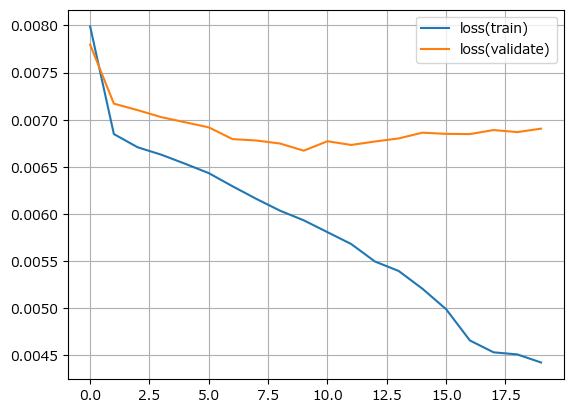

In [27]:
t_losses = history['train_loss_values']
t_accus = history['train_accuracy_values']
v_losses = history['valid_loss_values']
v_accus = history['valid_accuracy_values']

plot_graph(t_losses, v_losses, len(t_losses), 'loss(train)', 'loss(validate)')

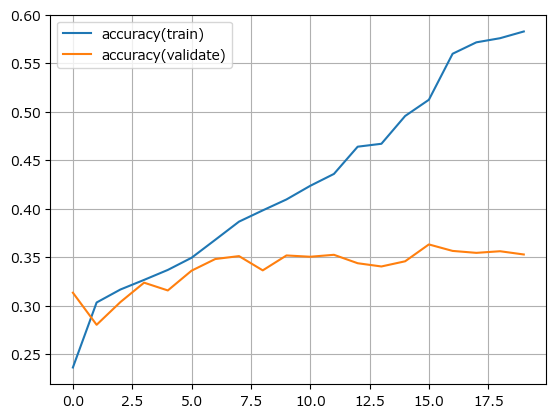

In [28]:
plot_graph(t_accus, v_accus, len(t_accus), 'accuracy(train)', 'accuracy(validate)')

## 取り置きのテスト画像群

In [29]:
test_fn = r'./dataset_cur_test.csv'
test_fn

'./dataset_cur_test.csv'

In [30]:
df_test = pd.read_csv(test_fn,index_col=0)
df_test = df_test.reset_index(drop=True)
df_test['red_diff'] = df_test['red_diff'].astype(np.float32)
df_test['remain_ends'] = df_test['remain_ends'].astype(np.float32)
df_test['last_stone_is_red'] = df_test['last_stone_is_red'].astype(np.float32)
df_test['red_postion'] = df_test['red_postion'].astype(np.float32)
display(df_test.dtypes)
display(df_test.head(3))

red_diff             float32
remain_ends          float32
last_stone_is_red    float32
red_postion          float32
filepath              object
dtype: object

,red_diff,remain_ends,last_stone_is_red,red_postion,filepath
0,-1.0,7.0,0.0,1.0,./dataset_o\WWCC2019_ResultsBook\geme428end2.png
1,-2.0,1.0,0.0,2.0,./dataset_o\WWCC2019_ResultsBook\geme531end8.png
2,2.0,7.0,1.0,0.0,./dataset_o\ECC2019_ResultsBook_Women_A-Divisi...


In [31]:
# 標準化
_stdsc = StandardScaler()
##学習時の標準化したパラメータは、評価、本番時におなじ重みで標準化する処理が必要
x_test_df = df_test.copy().drop(['filepath','red_diff'],axis=1)
sc = pickle.load(open(new_dir_path_recursive+'stdsc_02240209.pkl', "rb"))
x_test_std = sc.transform(x_test_df)

## DataFrameの値を入れ替え
qcl = df_test.columns.to_list()
qcl.remove('filepath')
qcl.remove('red_diff')
print(qcl)
df_test[qcl] = x_test_std
#df_test.head(3)

['remain_ends', 'last_stone_is_red', 'red_postion']


In [32]:
q_test = ImgValueDataset( df_test ,classcol='red_diff' , fncol='filepath' ,transform=transform_test)

In [45]:
## ベストモデル
import glob
##'model_scripted_{epoch}.smodel.pth'
g = glob.glob(new_dir_path_recursive+'model_scripted_*.smodel.pth')
g.sort()
fn = g[-1]
fn = new_dir_path_recursive + 'checkpoint_model.pth'
fn

'./mynet_b/checkpoint_model.pth'

In [49]:
print(fn)
model_from_script = torch.load(fn, map_location="cuda")
print(type(model_from_script))
net2 = SimpleCNN(11)
net2.load_state_dict(torch.load(fn))

./mynet_b/checkpoint_model.pth
<class 'collections.OrderedDict'>


<All keys matched successfully>

In [50]:
q_loader = DataLoader(q_test, batch_size=batch_size, shuffle=False, num_workers=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu_model = net2.to(device)
with torch.no_grad():
    accs = [] # 各バッチごとの結果格納用
    for batch in q_loader:
        x, t = batch
        x = x.to(device)
        t = t.to(device)
        y = gpu_model(x)
        
        y_label = torch.argmax(y, dim=1)
        t_label = torch.argmax(t, dim=1)
        acc = torch.sum(y_label == t_label) * 1.0 / len(t)
        accs.append(acc)
    

In [51]:
np.mean( list(map( lambda r:r.item() ,accs )) )

0.3560089298657009

In [ ]:
!nvidia-smi